# How to generate long-short trading signals with a Random Forest

## Imports & Settings

In [1]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from itertools import product
from pathlib import Path
import numpy as np
import pandas as pd
import statsmodels.api as sm
import talib
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from scipy.stats import spearmanr

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens.performance import mean_return_by_quantile
from alphalens.plotting import plot_quantile_returns_bar
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [4]:
YEAR = 252
idx = pd.IndexSlice

## Get Data

See the notebook [japanese_equity_features](03_japanese_equity_features.ipynb) in this directory for data preparation.

In [5]:
data = pd.read_hdf('data.h5', 'stooq/japan/equities')

data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1378040 entries, (1332.JP, 2014-01-06 00:00:00) to (9989.JP, 2019-12-30 00:00:00)
Data columns (total 23 columns):
ret_1              1377100 non-null float64
ret_rel_perc_1     1377100 non-null float64
ret_5              1373340 non-null float64
ret_rel_perc_5     1373340 non-null float64
ret_10             1368640 non-null float64
ret_rel_perc_10    1368640 non-null float64
ret_21             1358300 non-null float64
ret_rel_perc_21    1358300 non-null float64
ret_63             1318820 non-null float64
ret_rel_perc_63    1318820 non-null float64
PPO                1354540 non-null float64
NATR               1364880 non-null float64
RSI                1364880 non-null float64
bbl                1374280 non-null float64
bbu                1374280 non-null float64
weekday            1378040 non-null int64
month              1378040 non-null int64
year               1378040 non-null int64
fwd_ret_01         1377100 non-null float64
fwd_r

### Select universe of 250 most-liquid stocks

In [85]:
DATA_DIR = Path('..', 'data')
prices = (pd.read_hdf(DATA_DIR / 'stooq/daily.h5', 'jp/tse/stocks/prices')
          .loc[idx[:, '2014': '2019'], :])

dollar_vol = prices.close.mul(prices.volume).loc[idx[:, :'2017'],:]
dollar_vol_rank = dollar_vol.groupby(level='date').rank(ascending=False)
universe = dollar_vol_rank.groupby(level='symbol').mean().mul(-1).nlargest(250).index

## MultipleTimeSeriesCV

See [Chapter 7 - Linear Models](../07_linear_models) for details.

In [6]:
cv = MultipleTimeSeriesCV(n_splits=36,
                          test_period_length=21,
                          lookahead=5,
                          train_period_length=2 * 252)

In [7]:
for i, (train_idx, test_idx) in enumerate(cv.split(X=data)):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='symbol').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='symbol').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    if i == 3:
        break

508 2017-10-24 2019-11-25 21 2019-12-02 2019-12-30
508 2017-09-22 2019-10-24 21 2019-10-31 2019-11-29
508 2017-08-23 2019-09-20 21 2019-09-30 2019-10-30
508 2017-07-24 2019-08-21 21 2019-08-28 2019-09-27


## Model Selection: Time Period and Horizon

In [90]:
cv_data = data.loc[idx[universe, :'2017'], :]
tickers = cv_data.index.get_level_values('symbol').unique()

In [91]:
lookaheads = [1, 5, 10, 21]

## Baseline: Linear Regression

In [92]:
lr = LinearRegression()

In [93]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

In [94]:
train_lengths = [252, 126, 63]
test_lengths = [5, 21]

In [95]:
test_params = list(product(lookaheads, train_lengths, test_lengths))

In [96]:
lr_metrics = []
for lookahead, train_length, test_length in test_params:
    label = f'fwd_ret_{lookahead:02}'
    df = cv_data.loc[:, features + [label]].dropna()
    X, y = df.drop(label, axis=1), df[label]

    n_splits = int(2 * YEAR / test_length)
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    ic, preds = [], []
    for i, (train_idx, test_idx) in enumerate(cv.split(X=X)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        preds.append(y_test.to_frame('y_true').assign(y_pred=y_pred))
        ic.append(spearmanr(y_test, y_pred)[0])
    preds = pd.concat(preds)
    lr_metrics.append([
        lookahead, train_length, test_length,
        np.mean(ic),
        spearmanr(preds.y_true, preds.y_pred)[0]
    ])

columns = ['lookahead', 'train_length', 'test_length', 'ic_by_day', 'ic']
lr_metrics = pd.DataFrame(lr_metrics, columns=columns)

### Information Coefficient distribution by Lookahead

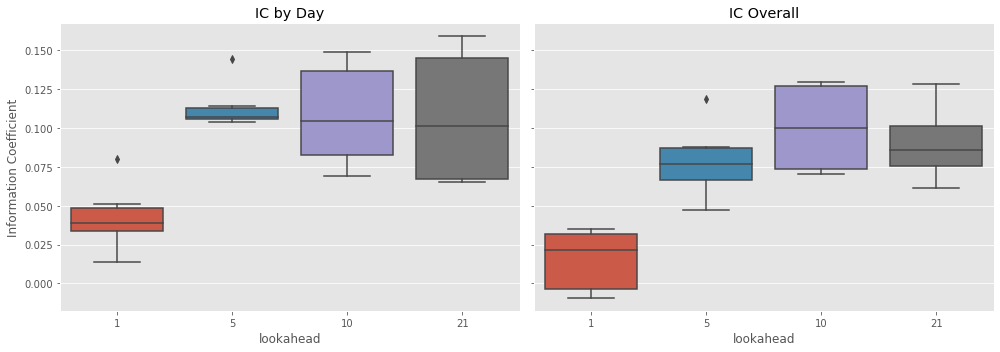

In [98]:
fig, axes =plt.subplots(ncols=2, figsize=(14,5), sharey=True)
sns.boxplot(x='lookahead', y='ic_by_day',data=lr_metrics, ax=axes[0])
axes[0].set_title('IC by Day')
sns.boxplot(x='lookahead', y='ic',data=lr_metrics, ax=axes[1])
axes[1].set_title('IC Overall')
axes[0].set_ylabel('Information Coefficient')
axes[1].set_ylabel('')
fig.tight_layout()
fig.savefig('figures/lr_ic', dpi=300);

### Best Train/Test Period Lengths

In [99]:
(lr_metrics.groupby('lookahead', group_keys=False)
 .apply(lambda x: x.nlargest(3, 'ic')))

,lookahead,train_length,test_length,ic_by_day,ic
5,1,63,21,0.033012,0.035147
3,1,126,21,0.013607,0.031625
1,1,252,21,0.042508,0.031069
11,5,63,21,0.144587,0.118644
9,5,126,21,0.107555,0.087864
10,5,63,5,0.105638,0.084423
14,10,126,5,0.090593,0.129589
16,10,63,5,0.069111,0.129061
15,10,126,21,0.143038,0.121092
23,21,63,21,0.159019,0.128485


In [100]:
lr_metrics.to_csv('lr_metrics.csv', index=False)

## LightGBM Random Forest Model Tuning

### Hyperparameter Options

In [ ]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

In [ ]:
bagging_fraction_opts = [.5, .75, .95]
feature_fraction_opts = [.25, .5, .75, .95]
min_data_in_leaf_opts = [250, 500, 1000]

In [ ]:
cv_params = list(product(bagging_fraction_opts,
                         feature_fraction_opts,
                         min_data_in_leaf_opts))
n_cv_params = len(cv_params)
n_cv_params

In [ ]:
num_iterations = list(range(25, 201, 25))
num_boost_round = num_iterations[-1]

### Train/Test Period Lenghts

In [101]:
train_lengths = [252, 126, 63]
test_lengths = [5, 21]

In [102]:
test_params = list(product(train_lengths, test_lengths))
n = len(test_params)
test_param_sample = np.random.choice(list(range(n)), size=int(n), replace=False)
test_params = [test_params[i] for i in test_param_sample]
print('Train configs:', len(test_params))

Train configs: 6


### Categorical Variables

In [ ]:
categoricals = ['year', 'weekday', 'month']
for feature in categoricals:
    data[feature] = pd.factorize(data[feature], sort=True)[0]

### Run Cross-Validation

In [ ]:
store = Path('parameter_tuning.h5')

In [ ]:
labels = sorted(cv_data.filter(like='fwd').columns)
features = cv_data.columns.difference(labels).tolist()

In [ ]:
label_dict = dict(zip(horizons, labels))

In [ ]:
store = Path(f'parameter_tuning_{lookahead:02}.h5')
metric_cols = ['bagging_fraction', 'feature_fraction',
               'min_data_in_leaf', 't'] + [str(n) for n in num_iterations]

In [ ]:
for train_length, test_length in test_params:
    cvp = np.random.choice(list(range(n_params)),
                           size=int(n_params),
                           replace=False)
    cv_params_ = [cv_params[i] for i in cvp]

    n_splits = int(2 * YEAR / test_length)
    print(f'Lookahead: {lookahead:2.0f} | Train: {train_length:3.0f} | '
          f'Test: {test_length:2.0f} | Params: {len(cv_params_):3.0f}')
    cv = MultipleTimeSeriesCV(n_splits=n_splits,
                              test_period_length=test_length,
                              lookahead=lookahead,
                              train_period_length=train_length)

    label = label_dict[lookahead]
    outcome_data = data.loc[:, features + [label]].dropna()

    lgb_data = lgb.Dataset(data=outcome_data.drop(label, axis=1),
                           label=outcome_data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    predictions, metrics, feature_importance, daily_ic = [], [], [], []
    key = f'{lookahead}/{train_length}/{test_length}'
    T = 0
    for p, (bagging_fraction, feature_fraction, min_data_in_leaf) in enumerate(cv_params_):
        params = base_params.copy()
        params.update(dict(bagging_fraction=bagging_fraction,
                           feature_fraction=feature_fraction,
                           min_data_in_leaf=min_data_in_leaf))

        start = time()
        cv_preds, nrounds = [], []
        ic_cv = defaultdict(list)
        for i, (train_idx, test_idx) in enumerate(cv.split(X=outcome_data)):
            lgb_train = lgb_data.subset(train_idx.tolist()).construct()
            lgb_test = lgb_data.subset(test_idx.tolist()).construct()

            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)
            if i == 0:
                fi = get_fi(model).to_frame()
            else:
                fi[i] = get_fi(model)

            test_set = outcome_data.iloc[test_idx, :]
            X_test = test_set.loc[:, model.feature_name()]
            y_test = test_set.loc[:, label]
            y_pred = {str(n): model.predict(X_test, num_iteration=n) for n in num_iterations}
            cv_preds.append(y_test.to_frame('y_test').assign(**y_pred).assign(i=i))
            nrounds.append(model.best_iteration)
        feature_importance.append(fi.T.describe().T.assign(bagging_fraction=bagging_fraction,
                                                           feature_fraction=feature_fraction,
                                                           min_data_in_leaf=min_data_in_leaf))
        cv_preds = pd.concat(cv_preds).assign(bagging_fraction=bagging_fraction,
                                              feature_fraction=feature_fraction,
                                              min_data_in_leaf=min_data_in_leaf)

        predictions.append(cv_preds)
        by_day = cv_preds.groupby(level='date')
        ic_by_day = pd.concat([by_day.apply(lambda x: spearmanr(x.y_test,
                                                                x[str(n)])[0]).to_frame(n)
                               for n in num_iterations], axis=1)

        daily_ic.append(ic_by_day.assign(bagging_fraction=bagging_fraction,
                                         feature_fraction=feature_fraction,
                                         min_data_in_leaf=min_data_in_leaf))

        ic = [spearmanr(cv_preds.y_test, cv_preds[str(n)])[0] for n in num_iterations]
        t = time() - start
        T += t
        metrics.append([bagging_fraction, feature_fraction,
                        min_data_in_leaf, t] + ic)

        msg = f'{p:3.0f} | {format_time(T)} ({t:3.0f}) | '
        msg += f'{bagging_fraction:3.0%} | {feature_fraction:3.0%} | {min_data_in_leaf:5,.0f} | '
        print(msg + f' {max(ic):6.2%} | {ic_by_day.mean().max(): 6.2%} | {ic_by_day.median().max(): 6.2%}')

    m = pd.DataFrame(metrics, columns=metric_cols)
    m.to_hdf(store, 'metrics/' + key)
    daily_ic = pd.concat(daily_ic)
    daily_ic.to_hdf(store, 'daily_ic/' + key)
    feature_importance = pd.concat(feature_importance)
    feature_importance.to_hdf(store, 'fi/' + key)
    predictions = pd.concat(predictions)
    predictions.to_hdf(store, 'predictions/' + key)

## Analyse Cross-Validation Results

### Collect Data

In [6]:
for t in [1, 5, 10, 21]:
    daily, metrics, predictions = [], [], []
    with pd.HDFStore(f'parameter_tuning_{t:02}.h5') as store:
        keys = [k[1:] for k in store.keys() if k.startswith(f'/fi/{t}')]
        for key in keys:
            train_length, test_length = key.split('/')[2:]
            k = f'{t}/{train_length}/{test_length}'
            cols = {
                't': t,
                'train_length': train_length,
                'test_length': test_length
            }
            metrics.append(store['metrics/' + k].assign(**cols))
            df = store['daily_ic/' + k].assign(**cols).reset_index()           
            df.index = np.array([[i]*len(df['date'].unique()) for i in range(len(metrics[-1]))]).flatten()
            df = df.join(metrics[-1].loc[:, ['bagging_fraction', 
                                              'feature_fraction', 
                                              'min_data_in_leaf']])

            daily.append(df)
            predictions.append(store['predictions/' + k].assign(**cols))
    predictions = pd.concat(predictions)
    metrics = pd.concat(metrics, ignore_index=True)
    daily_ic = pd.concat(daily, ignore_index=True)
    with pd.HDFStore('parameter_tuning.h5') as target:
        target.put(f'predictions/{t:02}', predictions)
        target.put(f'daily_ic/{t:02}', daily_ic)
        target.put(f'metrics/{t:02}', metrics)            

In [22]:
T = [1, 5, 10, 21]
with pd.HDFStore('parameter_tuning.h5') as store:
    daily_ic = pd.concat([store[f'daily_ic/{t:02}'] for t in T], ignore_index=True)
    metrics = pd.concat([store[f'metrics/{t:02}'] for t in T], ignore_index=True)

### Predictive Performance: CV Information Coefficient by Day

In [23]:
daily_ic.loc[:, ['train_length', 'test_length']] = daily_ic.loc[:, ['train_length', 'test_length']].astype(int)
daily_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451728 entries, 0 to 451727
Data columns (total 15 columns):
date                451728 non-null datetime64[ns]
25                  451391 non-null float64
50                  451551 non-null float64
75                  451577 non-null float64
100                 451589 non-null float64
125                 451594 non-null float64
150                 451594 non-null float64
175                 451594 non-null float64
200                 451595 non-null float64
t                   451728 non-null int64
train_length        451728 non-null int64
test_length         451728 non-null int64
bagging_fraction    451728 non-null float64
feature_fraction    451728 non-null float64
min_data_in_leaf    451728 non-null int64
dtypes: datetime64[ns](1), float64(10), int64(4)
memory usage: 51.7 MB


In [24]:
daily_long = pd.melt(daily_ic.dropna(), 
        id_vars=['bagging_fraction', 'feature_fraction', 'min_data_in_leaf', 't','train_length', 'test_length', 'date'],
       value_name='ic', 
        var_name='rounds')
daily_long.loc[:, ['rounds']] = daily_long.loc[:, ['rounds']].astype(int)
daily_long.info(null_counts='True')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3611128 entries, 0 to 3611127
Data columns (total 9 columns):
bagging_fraction    3611128 non-null float64
feature_fraction    3611128 non-null float64
min_data_in_leaf    3611128 non-null int64
t                   3611128 non-null int64
train_length        3611128 non-null int64
test_length         3611128 non-null int64
date                3611128 non-null datetime64[ns]
rounds              3611128 non-null int64
ic                  3611128 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 248.0 MB


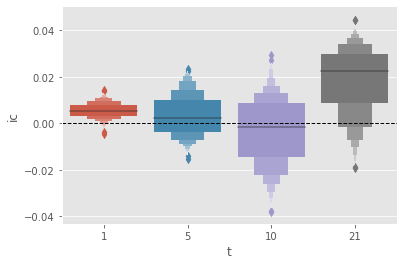

In [42]:
ax = sns.boxenplot(x='t', y='ic', data=daily_ic_avg)
ax.axhline(0, ls='--', lw=1, c='k');

In [38]:
group_cols = ['t','train_length', 'test_length', 
              'bagging_fraction', 'feature_fraction', 'min_data_in_leaf']
daily_ic_avg = daily_long.groupby(group_cols + ['rounds']).ic.mean().to_frame('ic').reset_index()
daily_ic_avg.groupby('t', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))

,t,train_length,test_length,bagging_fraction,feature_fraction,min_data_in_leaf,rounds,ic
1707,1,252,21,0.95,0.95,250,100,0.014424
1705,1,252,21,0.95,0.95,250,50,0.013991
850,1,126,5,0.95,0.95,500,75,0.013446
2641,5,126,21,0.50,0.75,250,50,0.023273
2642,5,126,21,0.50,0.75,250,75,0.022461
2648,5,126,21,0.50,0.75,500,25,0.022318
4400,10,126,21,0.50,0.95,500,25,0.029154
4415,10,126,21,0.50,0.95,1000,200,0.027394
4413,10,126,21,0.50,0.95,1000,150,0.026958
6088,21,126,21,0.50,0.50,1000,25,0.044567


### HyperParameter Impact: Linear Regression

In [ ]:
lin_reg = {}
for t in T:
    df_ = daily_long[daily_long.t==t]
    y, X = df_.ic, df_.drop(['ic'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err', 't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(f'lr_result_{t:02}.csv', index=False)

In [32]:
def visualize_lr_result(model, ax):
    ci = model.conf_int()
    errors = ci[1].sub(ci[0]).div(2)

    coefs = (model.params.to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith('date')&(coefs.variable!='const')]

    coefs.plot(x='variable', y='coef', kind='bar', 
                 ax=ax, color='none', capsize=3,
                 yerr='error', legend=False)
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

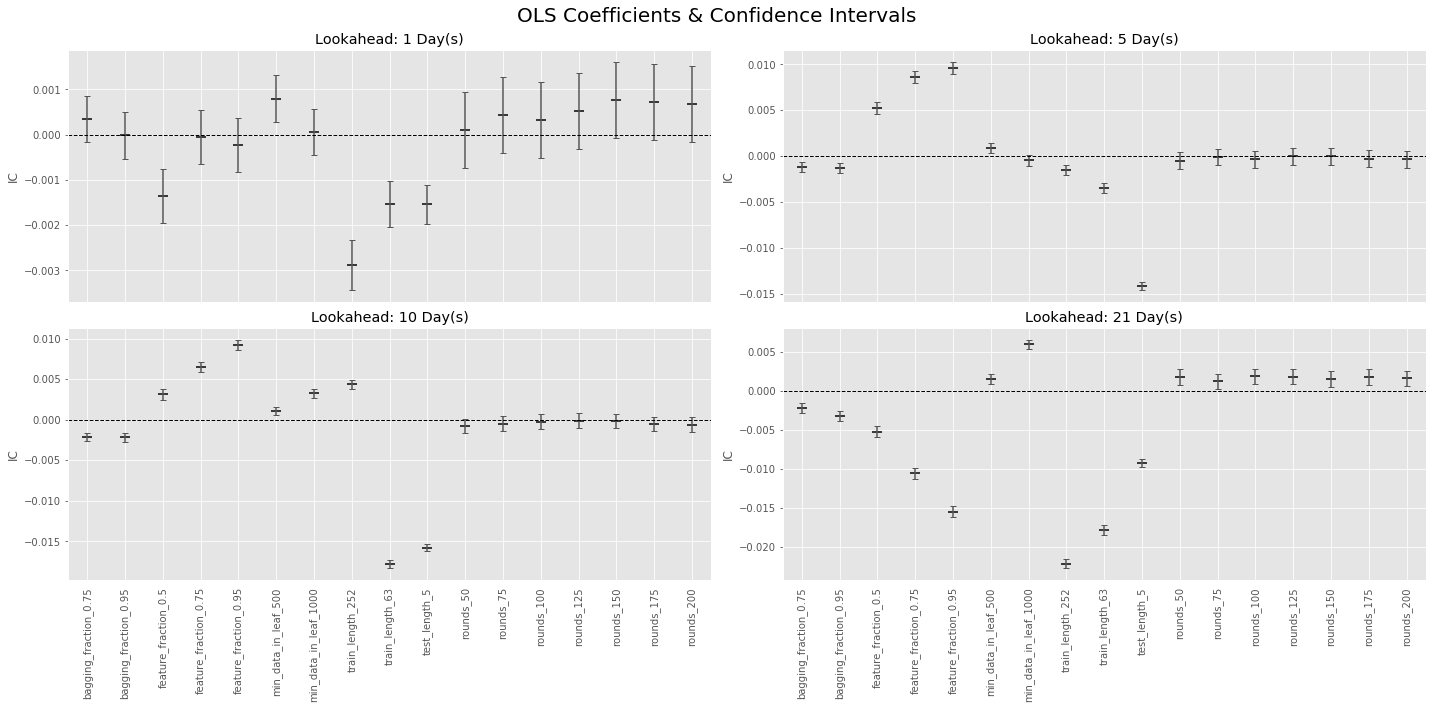

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), sharex=True)
axes = axes.flatten()
for i, t in enumerate(T):
    visualize_lr_result(lin_reg[t], axes[i])
    axes[i].set_title(f'Lookahead: {t} Day(s)')
fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.92)
fig.savefig('figures/ols_coefs', dpi=300);

### Information Coefficient: Overall

In [27]:
metrics_long = pd.melt(metrics, 
        id_vars=['bagging_fraction', 'feature_fraction', 'min_data_in_leaf', 't','train_length', 'test_length'],
       value_name='ic', 
        var_name='rounds')
metrics_long.loc[:, ['train_length', 'test_length', 'rounds']] = metrics_long.loc[:, ['train_length', 'test_length', 'rounds']].astype(int)
metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 8 columns):
bagging_fraction    7200 non-null float64
feature_fraction    7200 non-null float64
min_data_in_leaf    7200 non-null int64
t                   7200 non-null int64
train_length        7200 non-null int64
test_length         7200 non-null int64
rounds              7200 non-null int64
ic                  7200 non-null float64
dtypes: float64(3), int64(5)
memory usage: 450.1 KB


#### Best Parameters

In [36]:
metrics_long.groupby('t').apply(lambda x: x.nlargest(3, 'ic'))

bagging_fraction  feature_fraction  min_data_in_leaf   t  \
t                                                                   
1  3796              0.95              0.25               250   1   
   3815              0.75              0.25               250   1   
   2896              0.95              0.25               250   1   
5  347               0.75              0.75               500   5   
   335               0.75              0.75               250   5   
   340               0.95              0.75               250   5   
10 1581              0.95              0.50               250  10   
   4281              0.95              0.50               250  10   
   4274              0.75              0.50               250  10   
21 2508              0.75              0.75              1000  21   
   3408              0.75              0.75              1000  21   
   6108              0.75              0.75              1000  21   

         train_length  test_length  rounds        ic  
t                                                     
1  3796           126           21     125  0.022670  
   3815           126           21     125  0.021782  
   2896           126           21     100  0.021263  
5  347            252           21      25  0.059262  
   335            252           21      25  0.056818  
   340            252           21      25  0.056605  
10 1581           126            5      50  0.069697  
   4281           126            5     125  0.068498  
   4274           126            5     125  0.068360  
21 2508            63           21      75  0.168191  
   3408            63           21     100  0.167338  
   6108            63           21     175  0.166442

#### Visualiztion

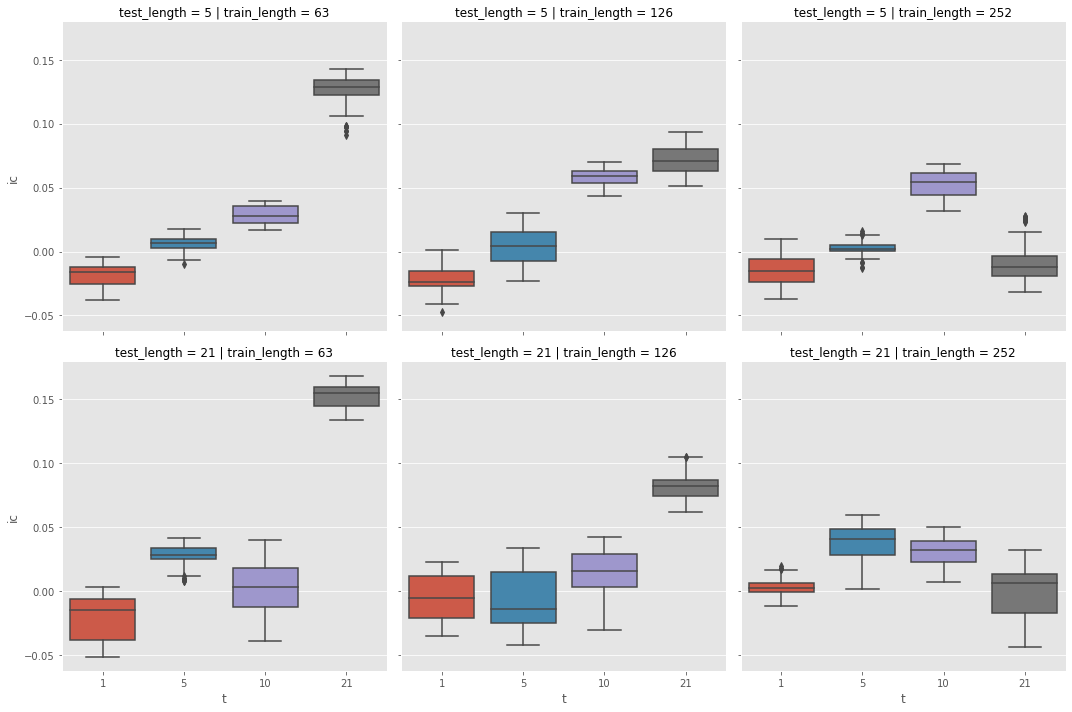

In [275]:
g = sns.catplot(x='t',
                y='ic',
                col='train_length',
                row='test_length',
                data=metrics_long,
                kind='box')
g.savefig('figures/catplot_all_t', dpi=300)

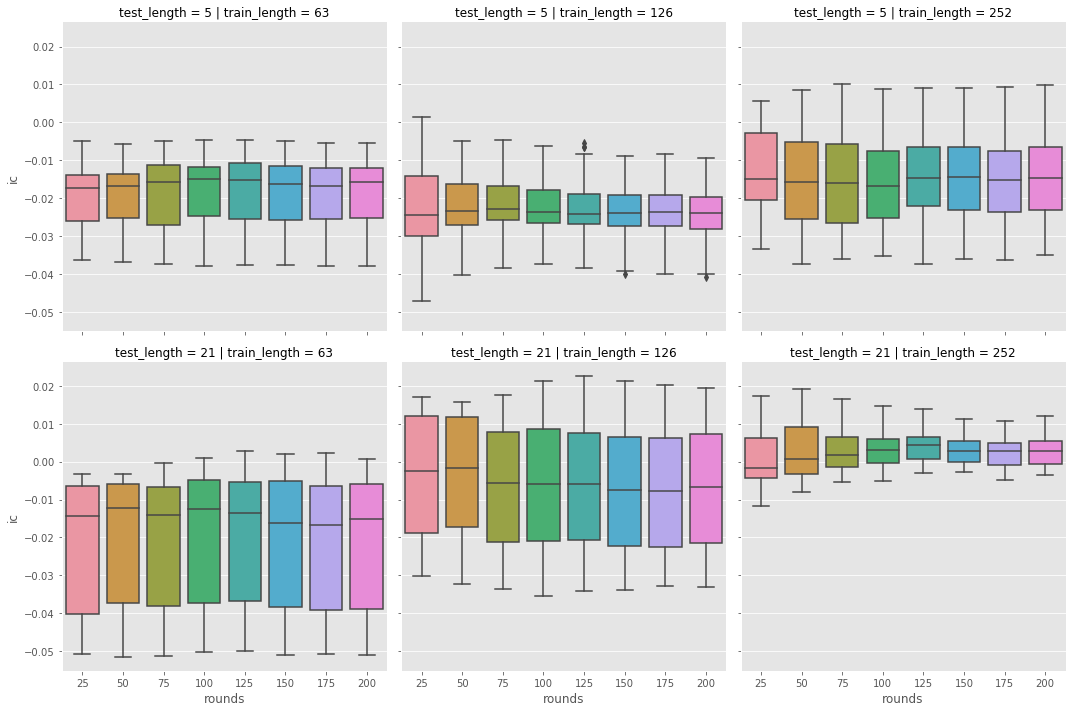

In [272]:
t = 1
g=sns.catplot(x='rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=metrics_long[metrics_long.t == t],
            kind='box')
# g.savefig('figures/catplot_05a', dpi=300);

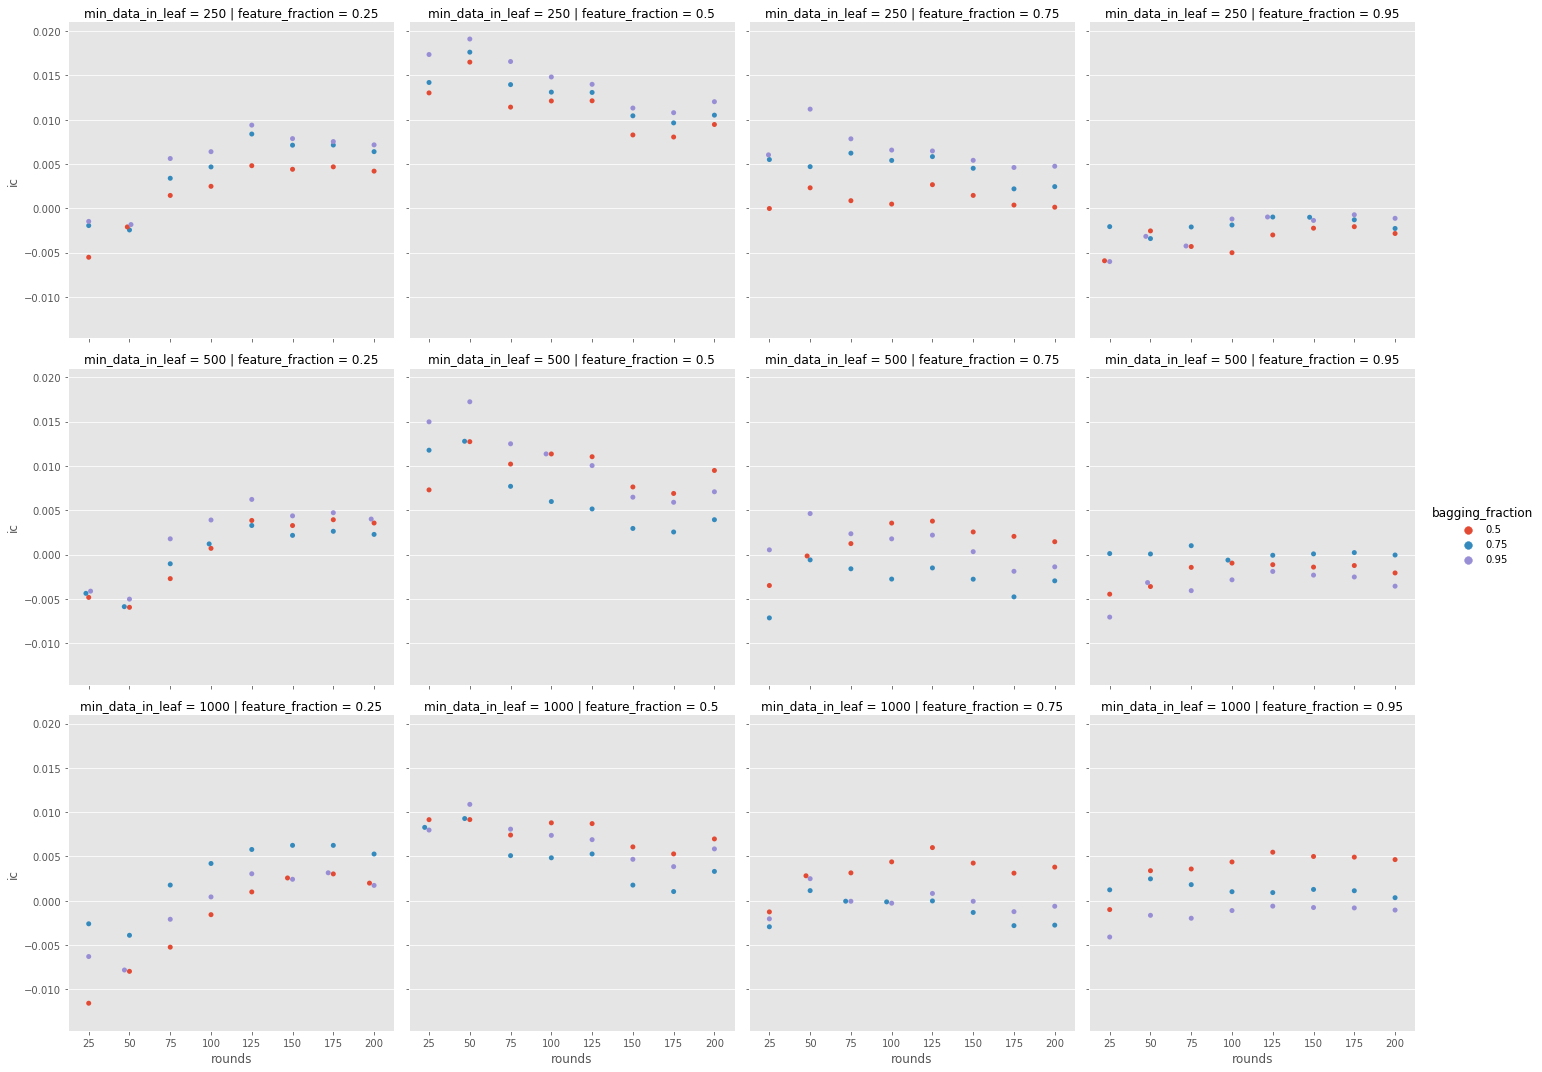

In [273]:
t = 1
train_length = 252
test_length = 21
g = sns.catplot(
    x='rounds',
    y='ic',
    col='feature_fraction',
    hue='bagging_fraction',
    row='min_data_in_leaf',
    data=metrics_long[(metrics_long.t == t)
                      & (metrics_long.train_length == train_length) &
                      (metrics_long.test_length == test_length)],
    kind='swarm')
# g.savefig('figures/catplot_05b', dpi=300);

### AlphaLens Analysis

#### Select Parameters

In [134]:
param_cols = ['train_length', 'test_length', 'bagging_fraction', 'feature_fraction', 'min_data_in_leaf', 'rounds']
def get_params(data, t=5, best=0):
    df = data[data.t==t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = str(int(df.rounds))
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

In [135]:
def get_predictions(preds, params, rounds, t=5):
    return preds.loc[
        (preds.train_length == params.train_length) &
        (preds.test_length == params.test_length) &
        (preds.bagging_fraction == params.bagging_fraction) &
        (preds.feature_fraction == params.feature_fraction) &
        (preds.min_data_in_leaf == params.min_data_in_leaf), rounds]

In [136]:
t = 1
topn= 10
predictions = pd.read_hdf('parameter_tuning.h5', f'predictions/{t:02}')
for best in range(topn):
    best_params, rounds = get_params(daily_ic_avg, t=t, best=best)
    if best == 0:
        best_predictions = get_predictions(predictions,
                                           best_params,
                                           rounds,
                                           t=t).to_frame(best)
    else:
        best_predictions[best] = get_predictions(predictions,
                                                 best_params,
                                                 rounds,
                                                 t=t)

In [143]:
best_predictions.to_hdf('predictions.h5', f'train/{t:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 114408 entries, (1605.JP, 2017-12-01 00:00:00) to (9984.JP, 2016-01-15 00:00:00)
Data columns (total 10 columns):
0    114408 non-null float64
1    114408 non-null float64
2    113500 non-null float64
3    114408 non-null float64
4    113500 non-null float64
5    114408 non-null float64
6    114408 non-null float64
7    114408 non-null float64
8    114408 non-null float64
9    113500 non-null float64
dtypes: float64(10)
memory usage: 9.2+ MB


#### Get AlphaLens Input

In [154]:
def get_trade_prices(tickers):
    store = Path('..', 'data') / 'stooq/daily.h5'
    prices = pd.read_hdf(store, 'jp/tse/stocks/prices')
    return (prices.loc[idx[tickers, '2014': '2019'], 'open']
            .unstack('symbol')
            .sort_index()
            .shift(-1)
            .dropna()
            .tz_localize('UTC'))

Using next available prices.

In [138]:
test_tickers = best_predictions.index.get_level_values('symbol').unique()
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2014-01-06 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 227 entries, 1605.JP to 9984.JP
dtypes: float64(227)
memory usage: 2.5 MB


In [139]:
factor = best_predictions.mean(1).tz_localize('UTC', level='date').swaplevel().dropna()

In [140]:
factor.head()

date                       symbol 
2017-12-01 00:00:00+00:00  1605.JP    0.001538
2017-12-04 00:00:00+00:00  1605.JP    0.000994
2017-12-05 00:00:00+00:00  1605.JP    0.000116
2017-12-06 00:00:00+00:00  1605.JP   -0.000416
2017-12-07 00:00:00+00:00  1605.JP   -0.001405
dtype: float64

In [141]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 114181 entries, (2015-12-14 00:00:00+00:00, 1605.JP) to (2017-12-29 00:00:00+00:00, 9984.JP)
Data columns (total 6 columns):
1D                 114181 non-null float64
5D                 114181 non-null float64
10D                114181 non-null float64
21D                114181 non-null float64
factor             114181 non-null float64
factor_quantile    114181 non-null int64
dtypes: float64(5), int64(1)
memory usage: 5.7+ MB


#### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.028449,0.008583,-0.002980,0.004363,23138,20.264317
2,-0.025788,0.009809,-0.001901,0.003963,22648,19.835174
3,-0.025143,0.011908,-0.001168,0.003883,22651,19.837801
4,-0.022627,0.020539,-0.000246,0.004003,22642,19.829919
5,-0.020924,0.032454,0.001554,0.004563,23102,20.232788


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.072,0.040,0.026,0.015
beta,0.075,0.065,0.075,0.062
Mean Period Wise Return Top Quantile (bps),5.470,2.946,2.342,1.871
Mean Period Wise Return Bottom Quantile (bps),-2.990,-2.445,-1.306,-0.749
Mean Period Wise Spread (bps),8.460,5.377,3.638,2.604


Information Analysis


,1D,5D,10D,21D
IC Mean,0.014,0.017,0.016,0.014
IC Std.,0.152,0.153,0.157,0.151
Risk-Adjusted IC,0.092,0.111,0.101,0.090
t-stat(IC),2.070,2.488,2.267,2.026
p-value(IC),0.039,0.013,0.024,0.043
IC Skew,0.235,0.604,0.462,0.285
IC Kurtosis,1.131,1.553,1.027,0.774


Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.759,0.669,0.791,0.722
Quantile 2 Mean Turnover,0.788,0.753,0.793,0.771
Quantile 3 Mean Turnover,0.799,0.764,0.800,0.787
Quantile 4 Mean Turnover,0.789,0.751,0.798,0.781
Quantile 5 Mean Turnover,0.728,0.627,0.767,0.696


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.281,0.186,0.113,0.035


<Figure size 432x288 with 0 Axes>

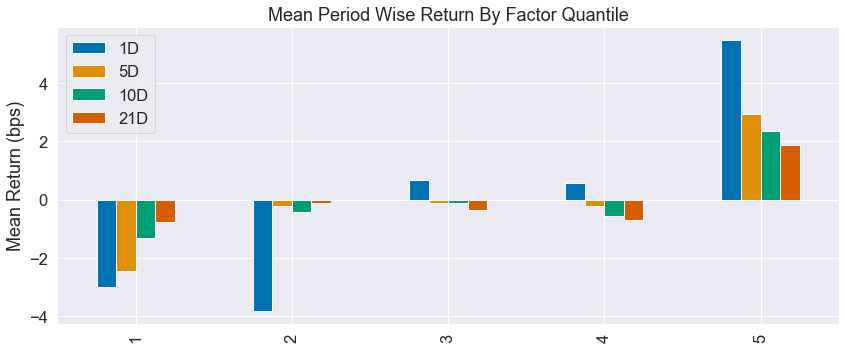

In [142]:
create_summary_tear_sheet(factor_data)

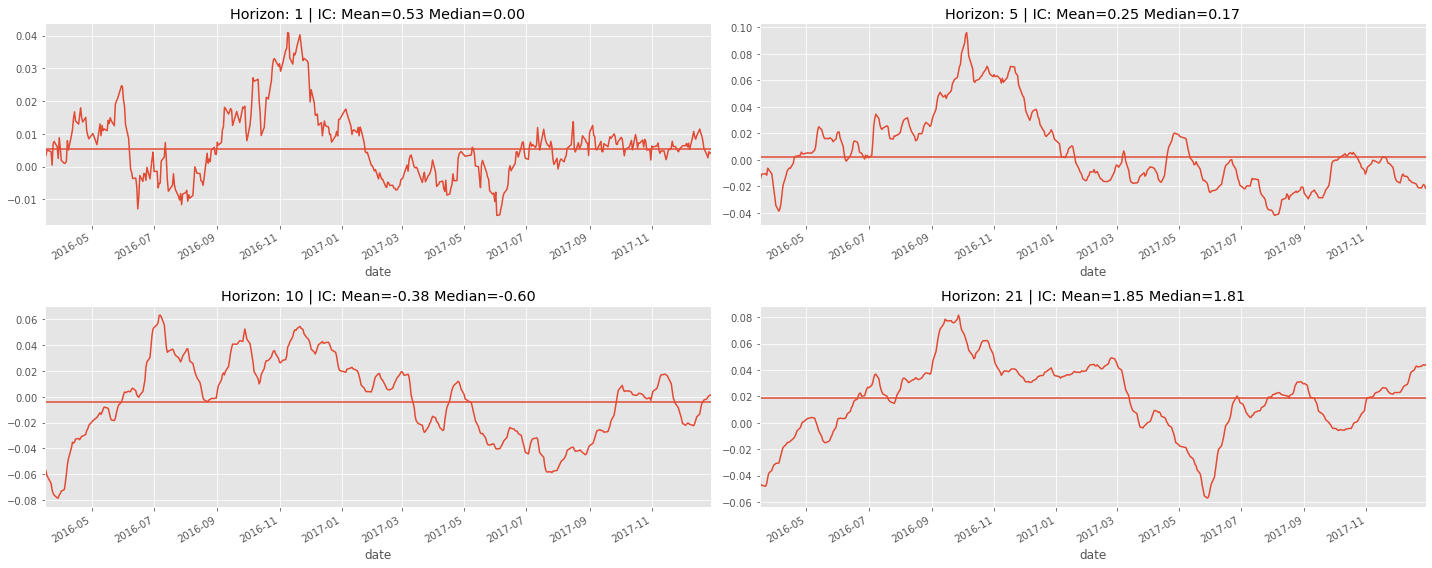

In [44]:
daily_ic_by_lookahead = daily_long.groupby(['date', 't']).ic.mean().unstack('t')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))
axes = axes.flatten()
rolling = daily_ic_by_lookahead.rolling(63).mean().dropna()
for i, t in enumerate(T):
    avg = daily_ic_by_lookahead[t].mean()
    med = daily_ic_by_lookahead[t].median()
    rolling[t].plot(ax=axes[i], title=f'Horizon: {t} | IC: Mean={avg*100:.2f} Median={med*100:.2f}')
    axes[i].axhline(avg)
    
fig.tight_layout();

### Random Forest vs Linear Regression 

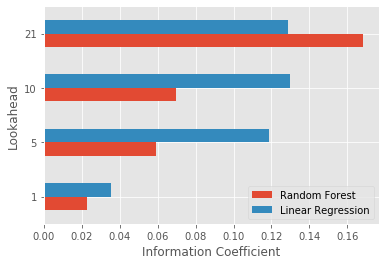

In [279]:
ax = (metrics_long.groupby('t').ic.max().to_frame('Random Forest')
 .join(lr_metrics.groupby('lookahead').ic.max().to_frame('Linear Regression')).plot.barh())
ax.set_ylabel('Lookahead')
ax.set_xlabel('Information Coefficient')
plt.savefig('figures/lr_vs_rf', dpi=300);

## Generate predictions

In [128]:
def get_params(data, t=5, best=0):
    df = data[data.t == t].sort_values('ic', ascending=False).iloc[best]
    df = df.loc[param_cols]
    rounds = int(df.rounds)
    params = pd.to_numeric(df.drop('rounds'))
    return params, rounds

In [129]:
base_params = dict(boosting_type='rf',
                   objective='regression',
                   bagging_freq=1,
                   verbose=-1)

store = Path('predictions.h5')

In [ ]:
for lookahead in [1, 5, 10, 21]:
    print(f'\nLookahead: {lookahead:02}')
    data = (pd.read_hdf('data.h5', 'stooq/japan/equities'))
    labels = sorted(data.filter(like='fwd').columns)
    features = data.columns.difference(labels).tolist()
    label = f'fwd_ret_{lookahead:02}'
    data = data.loc[idx[:, '2015':], features + [label]].dropna()

    categoricals = ['year', 'weekday', 'month']
    for feature in categoricals:
        data[feature] = pd.factorize(data[feature], sort=True)[0]

    lgb_data = lgb.Dataset(data=data.drop(label, axis=1),
                           label=data[label],
                           categorical_feature=categoricals,
                           free_raw_data=False)
    
    for position in range(10):
        params, num_boost_round = get_params(daily_ic_avg,
                                             t=lookahead,
                                             best=position)
        params = params.to_dict()
        params['min_data_in_leaf'] = int(params['min_data_in_leaf'])
        train_length = int(params.pop('train_length'))
        test_length = int(params.pop('test_length'))
        params.update(base_params)

        print(f'\tPosition: {position:02}')

        n_splits = int(2 * YEAR / test_length)
        cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                  test_period_length=test_length,
                                  lookahead=lookahead,
                                  train_period_length=train_length)

        predictions = []
        start = time()
        for i, (train_idx, test_idx) in enumerate(cv.split(X=data), 1):
            lgb_train = lgb_data.subset(train_idx.tolist()).construct()

            model = lgb.train(params=params,
                              train_set=lgb_train,
                              num_boost_round=num_boost_round,
                              verbose_eval=False)

            test_set = data.iloc[test_idx, :]
            y_test = test_set.loc[:, label].to_frame('y_test')
            y_pred = model.predict(test_set.loc[:, model.feature_name()])
            predictions.append(y_test.assign(prediction=y_pred))

        if position == 0:
            test_predictions = (pd.concat(predictions)
                                .rename(columns={'prediction': position}))
        else:
            test_predictions[position] = pd.concat(predictions).prediction
        

    by_day = test_predictions.groupby(level='date')
    for position in range(10):
        if position == 0:
            ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0]).to_frame()
        else:
            ic_by_day[position] = by_day.apply(lambda x: spearmanr(x.y_test, x[position])[0])
    print(ic_by_day.describe())
    ic_by_day.to_csv(f'ic_by_day_{t:02}.csv')

    key = f'{lookahead:02}'
    test_predictions.to_hdf(store, 'test/' + key)

### AlphaLens Analysis

#### Prepare Factor Data

In [266]:
t = 1
idx = pd.IndexSlice
predictions = (pd.read_hdf('predictions.h5', f'test/{t:02}')
                   .drop('y_test', axis=1)
                   .iloc[:, :3]
                   .mean(1)
                   .sort_index())

In [268]:
factor = predictions.tz_localize('UTC', level='date').swaplevel().dropna()
factor.head()

date                       symbol 
2017-12-05 00:00:00+00:00  1332.JP    0.002060
2017-12-06 00:00:00+00:00  1332.JP    0.001936
2017-12-07 00:00:00+00:00  1332.JP    0.001845
2017-12-08 00:00:00+00:00  1332.JP    0.002125
2017-12-11 00:00:00+00:00  1332.JP    0.002317
dtype: float64

#### Select next available trade prices

Using next available prices.

In [269]:
tickers = factor.index.get_level_values('symbol').unique()
trade_prices = get_trade_prices(tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2014-01-06 00:00:00+00:00 to 2019-12-27 00:00:00+00:00
Columns: 940 entries, 1332.JP to 9989.JP
dtypes: float64(940)
memory usage: 10.5 MB


#### Get AlphaLens Inputs

In [270]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 5, 10, 21))
factor_data.sort_index().info()

Dropped 19.6% entries from factor data: 4.2% in forward returns computation and 15.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 380700 entries, (2017-12-05 00:00:00+00:00, 1332.JP) to (2019-11-28 00:00:00+00:00, 9989.JP)
Data columns (total 6 columns):
1D                 380700 non-null float64
5D                 380700 non-null float64
10D                380700 non-null float64
21D                380700 non-null float64
factor             380700 non-null float64
factor_quantile    380700 non-null float64
dtypes: float64(6)
memory usage: 18.9+ MB


#### Summary Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.052407,0.011395,-0.002503,0.007156,81047,21.288941
2.0,-0.047542,0.011404,-0.001806,0.006642,76820,20.178618
3.0,-0.045472,0.011408,-0.001365,0.006531,75141,19.737589
4.0,-0.045085,0.021164,-0.000868,0.006604,74820,19.653270
5.0,-0.044751,0.032257,0.000260,0.006145,72872,19.141581


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,0.033,0.013,0.005,0.010
beta,-0.000,0.016,0.009,0.009
Mean Period Wise Return Top Quantile (bps),2.866,1.118,0.489,0.781
Mean Period Wise Return Bottom Quantile (bps),-0.404,-0.552,-0.376,-0.404
Mean Period Wise Spread (bps),3.270,1.659,0.858,1.184


Information Analysis


,1D,5D,10D,21D
IC Mean,0.005,0.007,0.007,0.012
IC Std.,0.099,0.104,0.100,0.102
Risk-Adjusted IC,0.050,0.069,0.074,0.114
t-stat(IC),1.004,1.389,1.482,2.293
p-value(IC),0.316,0.166,0.139,0.022
IC Skew,0.440,0.377,0.384,0.342
IC Kurtosis,1.211,0.804,1.552,1.533


Turnover Analysis


,10D,1D,21D,5D
Quantile 1 Mean Turnover,0.772,0.690,0.789,0.745
Quantile 2 Mean Turnover,0.796,0.765,0.799,0.794
Quantile 3 Mean Turnover,0.800,0.771,0.799,0.794
Quantile 4 Mean Turnover,0.801,0.765,0.801,0.788
Quantile 5 Mean Turnover,0.783,0.707,0.806,0.751


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.18,0.093,0.028,-0.008


<Figure size 432x288 with 0 Axes>

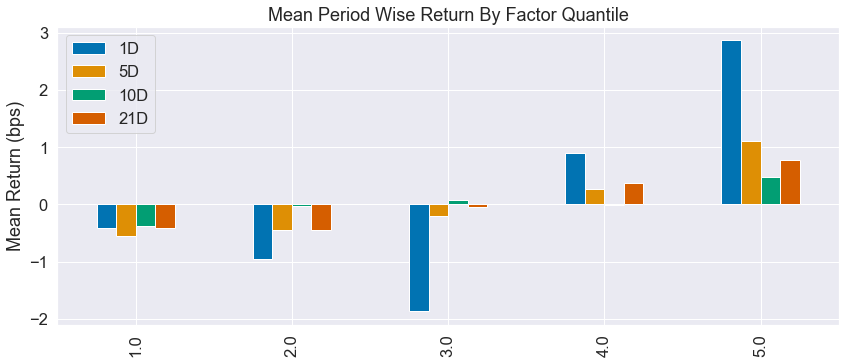

In [271]:
create_summary_tear_sheet(factor_data)

#### Full Tearsheet

In [ ]:
create_full_tear_sheet(factor_data,
                       long_short=True, 
                       group_neutral=False, 
                       by_group=True)